# Settings

In [1]:
import sys
import os

os.chdir('..')
os.getcwd()

'/Users/malthepabst/Documents/GitHub/ANLP-Project'

# Imports

In [2]:
#! pip install editdistance
#! pip install num2words

In [3]:
from scripts.model import device, CharBiLSTM
from scripts.data import create_data_loader, load_data
from scripts.preprocessing import get_typoglycemia_modified_data, sentence_tokennizer, tokenize_dataframe, get_max_length
from scripts.baseline import get_base_line_score

from torch import nn, optim
import torch

from sklearn.model_selection import train_test_split

import editdistance
#from tqdm import tqdm
# from tqdm.notebook import tqdm
from tqdm.autonotebook import trange, tqdm
import random 

from sklearn.metrics import f1_score, accuracy_score
import numpy as np



import pandas as pd
import matplotlib.pyplot as plt
random.seed(42)
torch.manual_seed(42);

device

/var/folders/dn/nd5kb8wx3xs44tlt7kst4n7h0000gn/T/ipykernel_21045/2117565946.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


device(type='cpu')

# Data

In [4]:
df_hard = load_data(file_path = "data/processed/sscorpus_hard.csv")
df_hard = df_hard[(~df_hard['typoglycemia'].isna())]

In [5]:
df_hard

,Hard,typoglycemia
0,on the Dover Air Force Base,on the Doevr Air Focre Base
1,in games including Super Smash Bros,in games iulnncidg Seupr Ssmah Bors
2,Usucha or thin tea is prepared with approximately,Uushca or tihn tea is ppraeerd with aptpxeormialy
3,grams amounting to,gmars autonimng to
4,heaping chashaku scoop or about half a teaspoo...,hanpeig cahahksu socop or aoubt half a toepsoa...
...,...,...
324667,He was elected to Rajya Sabha in,He was eeelctd to Rajya Sbhaa in
324668,The expression is not a polynomial because it ...,The eosrsxepin is not a pnoimalyol bceasue it ...
324669,Ithaca is in the rural Finger Lakes region abo...,Ithaca is in the rraul Fgneir Leaks rogien aou...
324670,The number of domino tilings of a checkerboard is,The numebr of dniomo tnigils of a cceraoekrbhd is


## Splitting data into train, val, test

In [6]:
dev, test = train_test_split(df_hard, test_size=0.2)
train, validation = train_test_split(dev, test_size=0.2)

## Baseline dev

In [7]:
get_base_line_score(train = train, test = test, type = 'Easy')

KeyError: 'Easy'

In [7]:
get_base_line_score(train = train, test = test, type = 'Hard')

The base line has a mean editdistance of 0.299 pr. sentence, and 0.299 pr. word


## Getting dataloaders

In [8]:
complexity_level = "Hard"

In [ ]:
#train = tokenize_dataframe(train, complexity_level)
#validation = tokenize_dataframe(validation, complexity_level)
#test = tokenize_dataframe(test, complexity_level)
#train

,Hard,typoglycemia
235963,it also has radioisotopes of which the longest...,it aslo has ritaoospiedos of wihch the lgtnoel...
68847,he worked for the bbc until on programmes incl...,he wreokd for the bbc until on pmmgreoars ilni...
176221,in hamlin ran his first full season in the nas...,in hlaimn ran his fsirt full seoasn in the nsa...
232147,he is perhaps best known for his role as paris...,he is pperhas best knwon for his role as prais...
146469,on december ian brown and john squire performe...,on debecemr ian brwon and jhon sriuqe prereomf...
...,...,...
211178,in the area s name bori means sack and bandar ...,in the aera s name bori means sack and badnar ...
1497,she became an adjunct instructor of political ...,she bmeace an adncjut itrtocnusr of pitcloial ...
125803,sdertlje is a city and the seat of sdertlje mu...,serltdje is a city and the saet of sdljrtee mt...
68116,in mexico a secretary of state is a member of ...,in meicxo a sceterray of state is a mbmeer of ...


In [10]:
combined_text = ' '.join(train["typoglycemia"])
unique_characters = set(combined_text)
vocabulary_size = len(unique_characters)
vocabulary_size

27

Five-number summary: Min: 9, Q1: 70.0, Median: 105.0, Q3: 150.0, Max: 1249
Mean: 116.58560366525658, Std Dev: 64.1532112660359


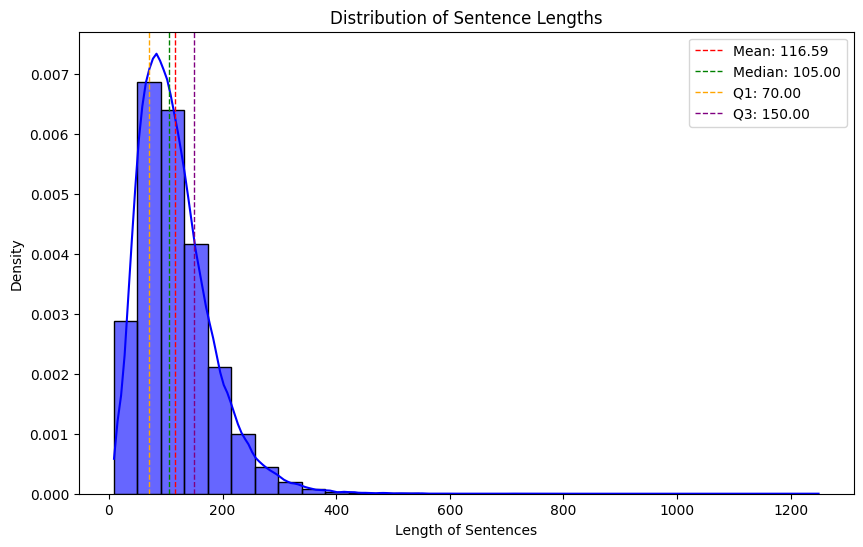

Five-number summary: Min: 9, Q1: 70.0, Median: 106.0, Q3: 151.0, Max: 901
Mean: 117.05865480865481, Std Dev: 64.90465974719932


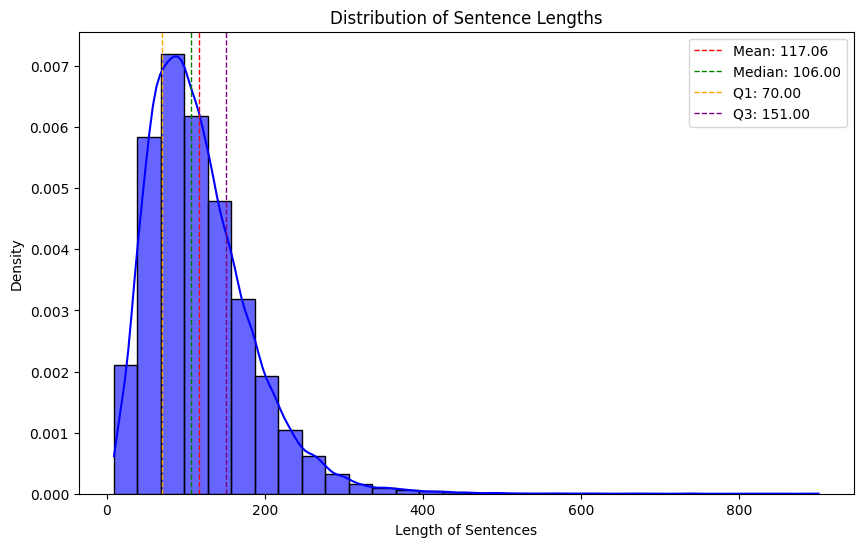

Five-number summary: Min: 9, Q1: 70.0, Median: 106.0, Q3: 151.0, Max: 892
Mean: 116.97509817509818, Std Dev: 64.55046131616432


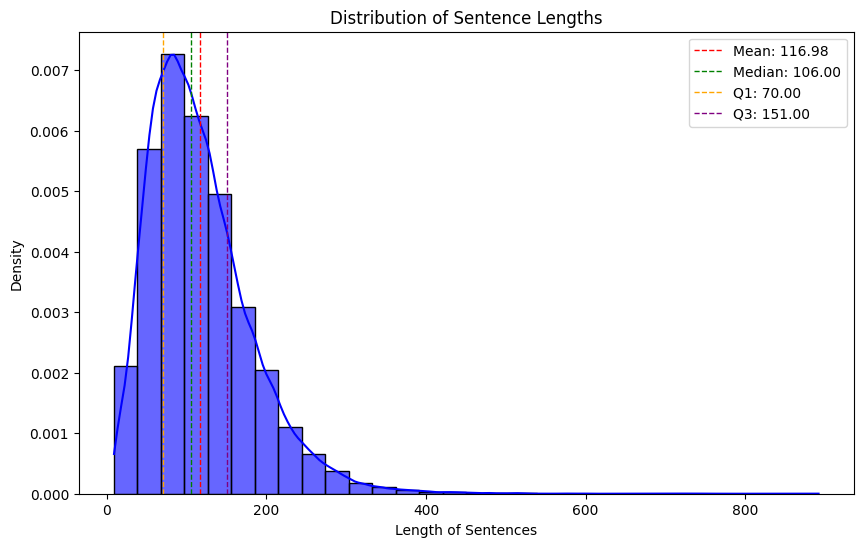

In [11]:
max_length_train = get_max_length(train, complexity_level)
max_length_validation = get_max_length(validation, complexity_level)
max_length_test = get_max_length(test, complexity_level)

In [12]:
max_length = max([max_length_train, max_length_validation, max_length_test])
max_length=300
max_length

300

In [13]:
all_sentences = pd.concat([df_hard[complexity_level], df_hard['typoglycemia']])
lengths = all_sentences.str.len()
lengths

0          27
1          35
2          49
3          18
4          78
         ... 
324667     32
324668     91
324669    223
324670     49
324671     83
Length: 649344, dtype: int64

In [14]:
batch_size = 2**8
# batch_size = 2

In [20]:
train

,Hard,typoglycemia
235963,it also has radioisotopes of which the longest...,it aslo has ritaoospiedos of wihch the lgtnoel...
68847,he worked for the bbc until on programmes incl...,he wreokd for the bbc until on pmmgreoars ilni...
176221,in hamlin ran his first full season in the nas...,in hlaimn ran his fsirt full seoasn in the nsa...
232147,he is perhaps best known for his role as paris...,he is pperhas best knwon for his role as prais...
146469,on december ian brown and john squire performe...,on debecemr ian brwon and jhon sriuqe prereomf...
...,...,...
211178,in the area s name bori means sack and bandar ...,in the aera s name bori means sack and badnar ...
1497,she became an adjunct instructor of political ...,she bmeace an adncjut itrtocnusr of pitcloial ...
125803,sdertlje is a city and the seat of sdertlje mu...,serltdje is a city and the saet of sdljrtee mt...
68116,in mexico a secretary of state is a member of ...,in meicxo a sceterray of state is a mbmeer of ...


In [15]:
train_loader = create_data_loader(train, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 
validation_loader = create_data_loader(validation, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 
test_loader = create_data_loader(test, complexity=complexity_level, max_length=max_length, batch_size=batch_size) # TODO 

In [16]:
for sample in train_loader:
    X, y = sample
    print(X.shape, y.shape)
    print(np.unique(y.cpu(), return_counts=True))
    break

torch.Size([256, 300]) torch.Size([256, 300])
(array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([46846,  2256,   423,   839,   993,  2898,   590,   489,  1191,
        1932,    75,   186,  1044,   599,  1996,  1839,   518,    33,
        1658,  1664,  2037,   656,   238,   442,    38,   402,  4918]))


In [17]:
ord('a') - ord('a') + 1

1

# Model  (Not finished just a template)

In [23]:
vocabulary_size

27

In [18]:
input_size = vocabulary_size 
input_size = 1  # Uses the raw index in alphabet as input
hidden_size = 2**6 # Maps to hidden size
output_size = vocabulary_size +  1  # Outputs probabilities for each character in vocabulary + padding
num_layers = 1   

model = CharBiLSTM(input_size, hidden_size, output_size, num_layers, max_length, batch_size).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=-1).to(device) # Padding is value -1, therefore we want to ignore it in our loss function
optimizer = optim.Adam(model.parameters(), lr=0.02, amsgrad=True)

epochs = 3

# Training

In [19]:
val_loss_dc = {}
train_loss_dc = {}

for epoch in tqdm(range(epochs), position=0):
    model.train()
    epoch_loss = 0.0    
    for batch in tqdm(train_loader, position=1, leave=False):
        typo_batch, sentence_batch = batch  
        
        sentence_batch = sentence_batch.view(-1)
        typo_batch = typo_batch.reshape(-1, max_length, 1)

        y = model.forward(typo_batch, train=False)  
        loss = loss_function(y, sentence_batch)  
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    epoch_loss_avg = epoch_loss / len(train_loader)
    train_loss_dc[epoch] = epoch_loss_avg

    model.eval()
    val_loss = 0.0
    with torch.no_grad():  
        for val_batch in tqdm(validation_loader, position=2, leave=False):
            typo_val_batch, sentence_val_batch = val_batch
            
            sentence_val_batch = sentence_val_batch.view(-1)
            typo_val_batch = typo_val_batch.reshape(-1, max_length, 1)
            
            val_y = model.forward(typo_val_batch, train=False)
            
            val_loss_batch = loss_function(val_y, sentence_val_batch)
            val_loss += val_loss_batch.item()
                
    val_loss_avg = val_loss / len(validation_loader)
    val_loss_dc[epoch] = val_loss_avg
    
    print(f"Epoch {epoch + 1}/{epochs} Train Loss: {epoch_loss_avg:.8f} Val Loss: {val_loss_avg:.8f}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'Cross Entropy Loss')

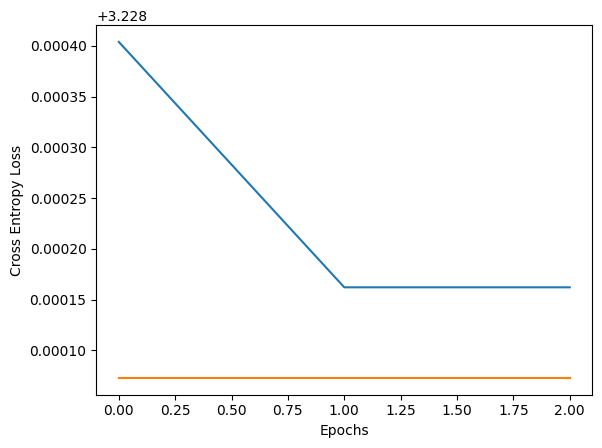

In [38]:
plt.plot(train_loss_dc.keys(), train_loss_dc.values(), label="Train Loss")
plt.plot(val_loss_dc.keys(), val_loss_dc.values(), label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

# Evaluation

In [39]:
def index_to_char(index, target = True):
    if target == False:
        index = index*100
    index = int(index)
    if 1 <= index <= 25:
        return chr(index + ord('a') - 1)
    elif index == 26:
        return ' '
    else:
        return "_"  # for all other values, return None

In [40]:
import csv

def get_metrics(loader, model, loader_str, output_file="output.csv", sample_size=10):
    preds = []
    labels = []
    inputs = []  # To store input sequences
    
    model.eval()
    loss = 0.0
    csv_data = [["Input Word", "Label Word", "Predicted Word"]]  # CSV header
    sentence_label = []
    sentence_pred = []
    sentence_input = []  # To store input words
    word_label = []
    word_pred = []
    word_input = []

    with torch.no_grad():
        for batch in tqdm(loader, position=3, leave=False):
            typo_batch, sentence_batch = batch  # typo_batch is the input, sentence_batch is the target sequence

            # Reshape inputs for model and get predictions
            sentence_batch = sentence_batch.view(-1)
            typo_batch = typo_batch.reshape(-1, max_length, 1)
            y = model.forward(typo_batch, train=False)  # y should be shape (batch_size, seq_len, vocab_size)
            
            # Calculate and accumulate loss
            loss_batch = loss_function(y, sentence_batch)
            loss += loss_batch.item()
            
            # Get predictions, labels, and inputs in a flattened form
            batch_preds = torch.argmax(y, dim=1).cpu().numpy().reshape(-1)
            batch_labels = sentence_batch.cpu().numpy().reshape(-1)
            batch_inputs = typo_batch.cpu().numpy().reshape(-1)
            
            # Append these results for later accuracy and F1 calculations
            preds.extend(batch_preds)
            labels.extend(batch_labels)
            inputs.extend(batch_inputs)
            
            # Process each element in the batch
            for label_idx in range(len(batch_preds)):
                label_char = index_to_char(batch_labels[label_idx])
                pred_char = index_to_char(batch_preds[label_idx])
                input_char = index_to_char(batch_inputs[label_idx],target = False)
                
                # Ignore padding characters
                if label_char != "_":
                    word_label.append(label_char)
                if pred_char != "_":
                    word_pred.append(pred_char)
                if input_char != "_":
                    word_input.append(input_char)
                
                # If end of a word (detected by space), append word to csv_data
                if label_char == " ":
                    # Join and append the completed word to csv data
                    csv_data.append(["".join(word_input), "".join(word_label), "".join(word_pred)])
                    # Clear the lists for the next word
                    word_label = []
                    word_pred = []
                    word_input = []
                
    # Write data to CSV file
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Display a subset of rows in the old format for console output
    print(f"\nDisplaying the first {sample_size} rows from the output file:\n")
    print("Input Word      | Label Word      | Predicted Word")
    print("-" * 50)
    for row in csv_data[1:sample_size + 1]:  # Skip header row, take only `sample_size` rows
        print(f"{row[0]:<15} | {row[1]:<15} | {row[2]}")
    
    # Compute and display metrics
    loss_avg = loss / len(loader)
    print(f"\n{loader_str} Loss: {loss_avg:.4f}")
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    print(f"\n{loader_str} Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


In [41]:
n_print = 100

In [42]:
get_metrics(train_loader, model, "train", "train_predictions.csv", n_print)

  0%|          | 0/1233 [00:00<?, ?it/s]


Displaying the first 100 rows from the output file:

Input Word      | Label Word      | Predicted Word
--------------------------------------------------
otrerneecy      | presented       |           
ayy             | by              |    
rnerbijry       | snickers        |          
brngebtry       | cruncher        |          
ity             | it              |    
toojy           | took            |      
okbey           | place           |       
ony             | on              |    
oirky           | april           |       
ty              | at              |    
tgey            | the             |     
rkniety         | reliant         |         
rotclroey       | astrodome       |           
iny             | in              |    
gottorny        | houston         |         
twertgey        | texasthe        |                                                                                                                                                                    

In [ ]:
get_metrics(validation_loader, model, "validation", "validation_predictions.csv", n_print)

In [ ]:
get_metrics(test_loader, model, "test", "test_predictions.csv", n_print)